<a href="https://colab.research.google.com/github/DarShabi/ITC-Final-Project-Scooters/blob/REDUCING-OVERFIT/Transfer_Learning_Model_reduced_overfit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

hi

In [131]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout
from keras.regularizers import l2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [132]:
IMAGE_SIZE = [300, 150]

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
!ls '/content/drive/MyDrive/LabeledScooters/Final_Folder/ORIGINAL/4RESIZED_FRAMES_BLACK_N_WHITE'

TEST  TRAIN  VALIDATION


In [135]:
train_path = '/content/drive/MyDrive/LabeledScooters/Final_Folder/ORIGINAL/4RESIZED_FRAMES_BLACK_N_WHITE/TRAIN'
validation_path = '/content/drive/MyDrive/LabeledScooters/Final_Folder/ORIGINAL/4RESIZED_FRAMES_BLACK_N_WHITE/VALIDATION'
test_path = '/content/drive/MyDrive/LabeledScooters/Final_Folder/ORIGINAL/4RESIZED_FRAMES_BLACK_N_WHITE/TEST'

In [136]:
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [137]:

for layer in vgg.layers:
  layer.trainable = False

In [138]:
folders = glob('/content/drive/MyDrive/LabeledScooters/Final_Folder/ORIGINAL/4RESIZED_FRAMES_COLOR/TRAIN/*')
print(len(folders))

4


In [139]:
x = Flatten()(vgg.output)
x = Dropout(0.5)(x) # Dropout layer
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 75, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 75, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 75, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 37, 128)       0   

In [140]:
from keras import optimizers


adam = optimizers.Adam(learning_rate = 0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [141]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [142]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [143]:
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
    )

In [144]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (300, 150),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1525 images belonging to 4 classes.


In [145]:
validation_set = test_datagen.flow_from_directory(validation_path,
                                            target_size = (300, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 484 images belonging to 4 classes.


In [146]:
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (300, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 400 images belonging to 4 classes.


In [147]:
class_indices = train_set.class_indices

# Get the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(train_path, class_name))) for class_name in class_indices}

# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Class: 0, Count: 504
Class: 1, Count: 471
Class: 2, Count: 226
Class: 3, Count: 324


In [148]:
class_indices = validation_set.class_indices

# Get the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(validation_path, class_name))) for class_name in class_indices}

# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Class: 0, Count: 148
Class: 1, Count: 193
Class: 2, Count: 59
Class: 3, Count: 84


In [149]:
class_indices = test_set.class_indices

# Get the number of images per class
class_counts = {class_name: len(os.listdir(os.path.join(test_path, class_name))) for class_name in class_indices}

# Print the number of images per class
for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Count: {count}")

Class: 0, Count: 90
Class: 1, Count: 144
Class: 2, Count: 50
Class: 3, Count: 116


In [150]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)


checkpoint = ModelCheckpoint(filepath='mymodel.h5',
                             monitor='val_accuracy',  # Monitor validation accuracy
                             verbose=1,
                             save_best_only=True,
                             mode='max')  # Save the best model based on the maximum validation accuracy

# Learning Rate Schedule
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)


callbacks = [checkpoint]


start = datetime.now()

model_history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=10,
    callbacks=callbacks,
    verbose=2
)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10

Epoch 1: val_accuracy improved from -inf to 0.56612, saving model to mymodel.h5
48/48 - 10s - loss: 2.6597 - accuracy: 0.4341 - val_loss: 1.4201 - val_accuracy: 0.5661 - 10s/epoch - 201ms/step
Epoch 2/10

Epoch 2: val_accuracy improved from 0.56612 to 0.67562, saving model to mymodel.h5
48/48 - 9s - loss: 1.4133 - accuracy: 0.6682 - val_loss: 1.1372 - val_accuracy: 0.6756 - 9s/epoch - 183ms/step
Epoch 3/10

Epoch 3: val_accuracy improved from 0.67562 to 0.70868, saving model to mymodel.h5
48/48 - 9s - loss: 1.0830 - accuracy: 0.7652 - val_loss: 1.0744 - val_accuracy: 0.7087 - 9s/epoch - 188ms/step
Epoch 4/10

Epoch 4: val_accuracy improved from 0.70868 to 0.73760, saving model to mymodel.h5
48/48 - 9s - loss: 0.7920 - accuracy: 0.8170 - val_loss: 1.0670 - val_accuracy: 0.7376 - 9s/epoch - 194ms/step
Epoch 5/10

Epoch 5: val_accuracy did not improve from 0.73760
48/48 - 9s - loss: 0.6128 - accuracy: 0.8656 - val_loss: 1.0444 - val_accuracy: 0.7273 - 9s/epoch - 191ms/step
Epo

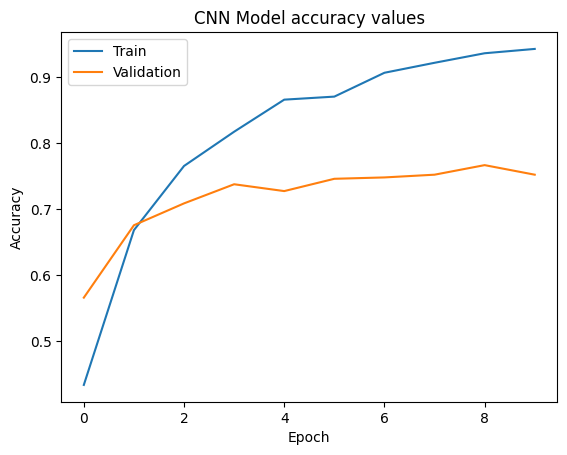

In [151]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('CNN Model accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [152]:
from sklearn.metrics import confusion_matrix

test_images, test_labels = [], []

for i in range(len(test_set)):
    batch_images, batch_labels = test_set[i]
    test_images.append(batch_images)
    test_labels.append(np.argmax(batch_labels, axis=1))

test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Make predictions using the trained model
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

13/13 [==============================] - 2s 133ms/step
Confusion Matrix:
[[ 51   6   0  33]
 [ 13 127   0   4]
 [  0   1  46   3]
 [ 41   1   3  71]]


In [153]:
indices = np.where(test_labels != predicted_labels)

Predicted label: 0, True lable: 3


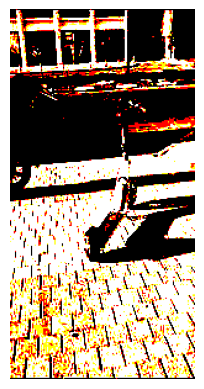

Predicted label: 0, True lable: 1


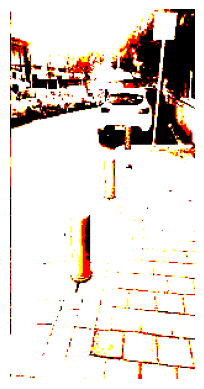

Predicted label: 0, True lable: 3


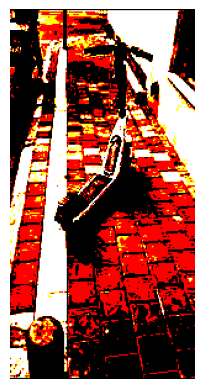

Predicted label: 3, True lable: 0


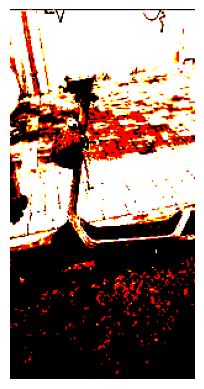

Predicted label: 0, True lable: 1


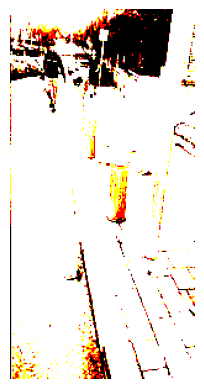

Predicted label: 0, True lable: 1


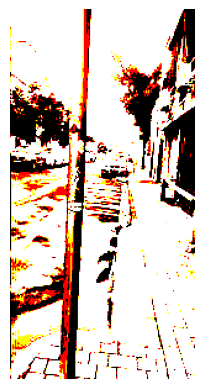

Predicted label: 3, True lable: 2


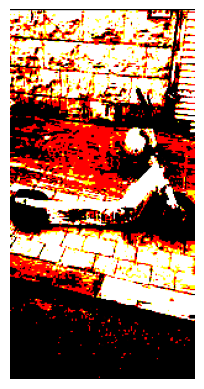

Predicted label: 3, True lable: 0


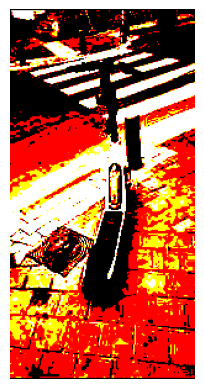

Predicted label: 3, True lable: 0


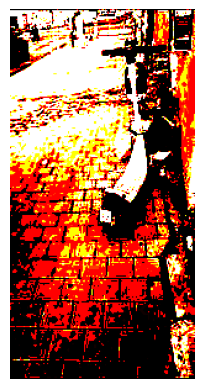

Predicted label: 3, True lable: 0


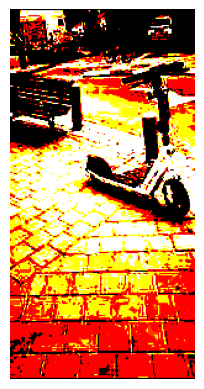

Predicted label: 0, True lable: 3


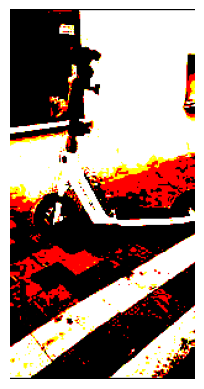

Predicted label: 3, True lable: 1


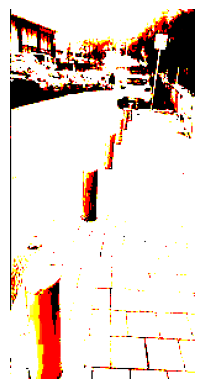

Predicted label: 0, True lable: 1


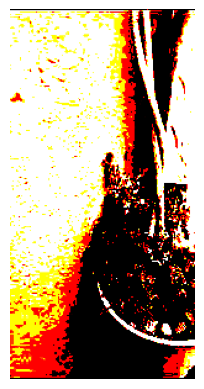

Predicted label: 0, True lable: 3


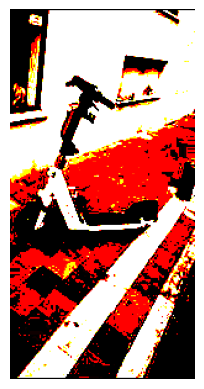

Predicted label: 0, True lable: 1


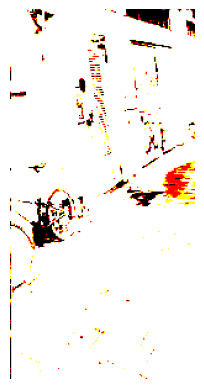

Predicted label: 0, True lable: 1


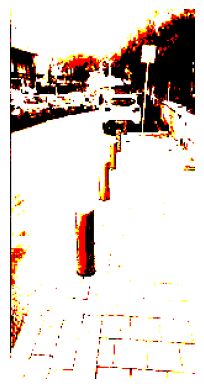

Predicted label: 2, True lable: 3


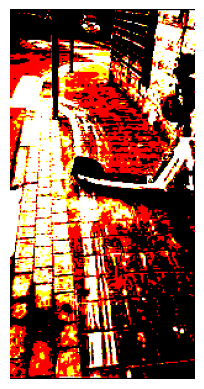

Predicted label: 3, True lable: 0


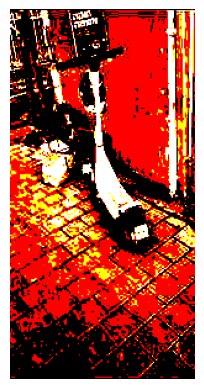

Predicted label: 0, True lable: 3


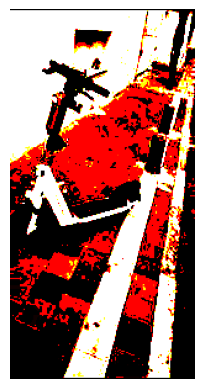

Predicted label: 0, True lable: 3


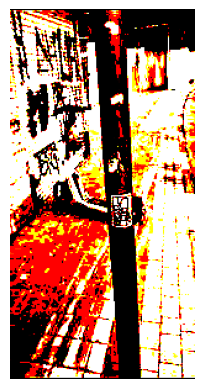

Predicted label: 3, True lable: 0


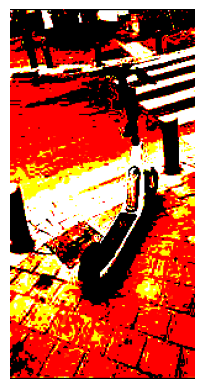

Predicted label: 1, True lable: 0


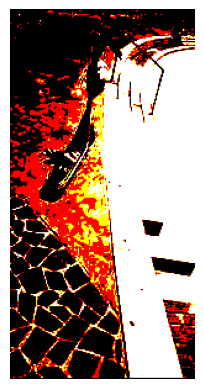

Predicted label: 3, True lable: 0


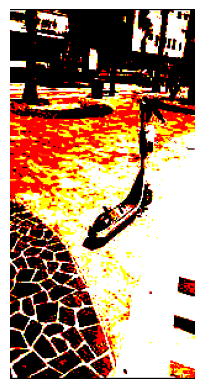

Predicted label: 3, True lable: 0


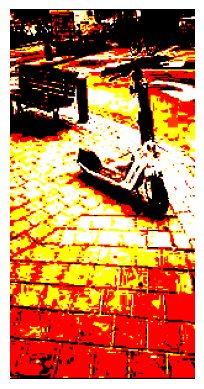

Predicted label: 3, True lable: 0


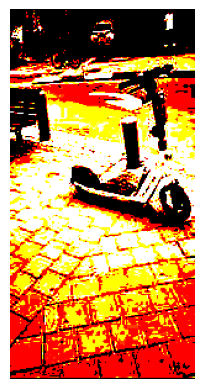

Predicted label: 3, True lable: 0


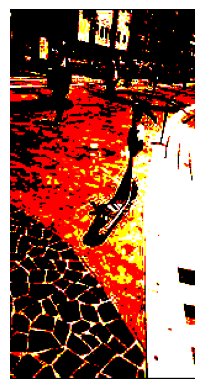

Predicted label: 0, True lable: 3


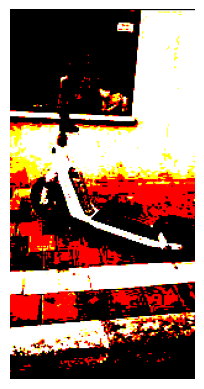

Predicted label: 0, True lable: 3


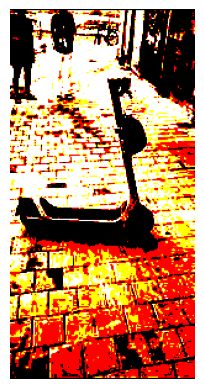

Predicted label: 1, True lable: 0


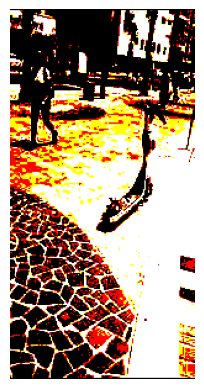

Predicted label: 0, True lable: 3


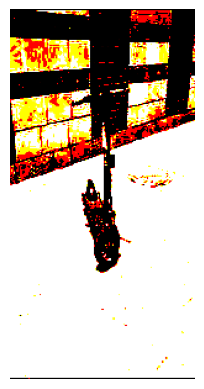

Predicted label: 0, True lable: 3


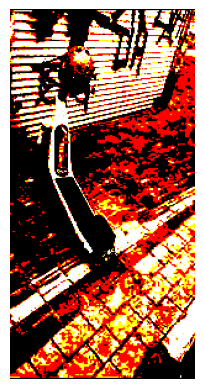

Predicted label: 1, True lable: 2


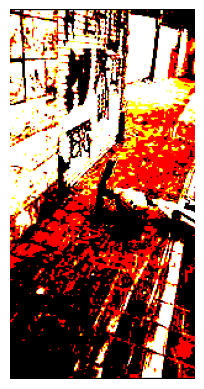

Predicted label: 0, True lable: 1


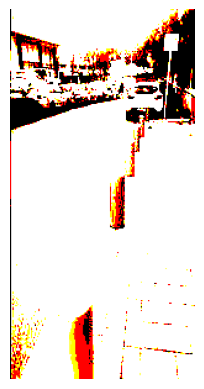

Predicted label: 3, True lable: 0


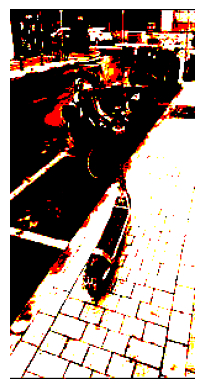

Predicted label: 3, True lable: 0


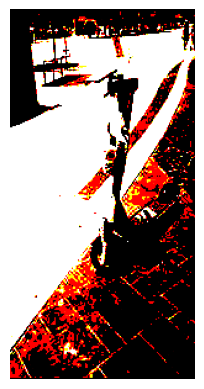

Predicted label: 1, True lable: 3


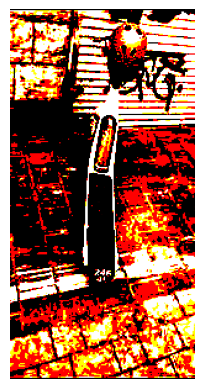

Predicted label: 0, True lable: 3


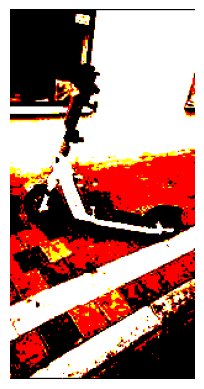

Predicted label: 3, True lable: 2


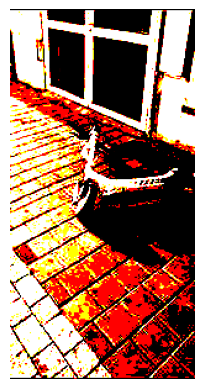

Predicted label: 3, True lable: 0


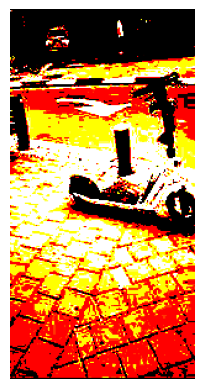

Predicted label: 0, True lable: 1


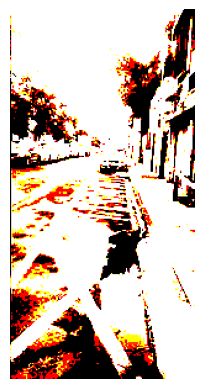

Predicted label: 0, True lable: 3


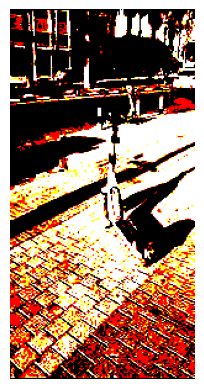

Predicted label: 0, True lable: 3


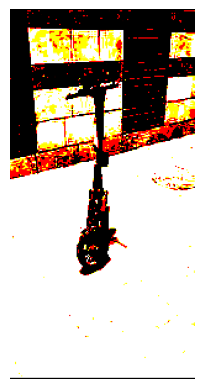

Predicted label: 3, True lable: 0


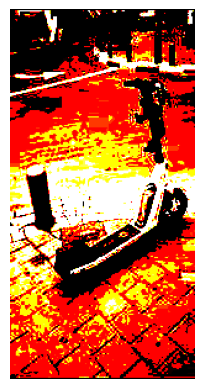

Predicted label: 0, True lable: 3


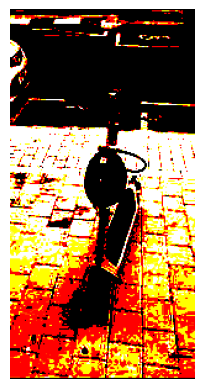

Predicted label: 0, True lable: 3


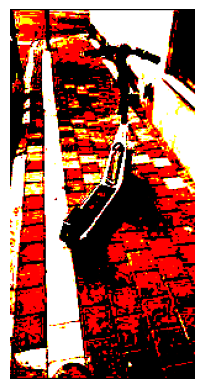

Predicted label: 0, True lable: 3


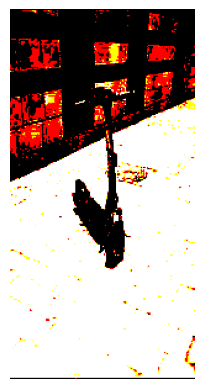

Predicted label: 3, True lable: 0


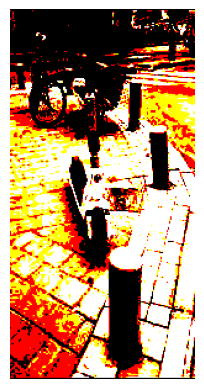

Predicted label: 0, True lable: 1


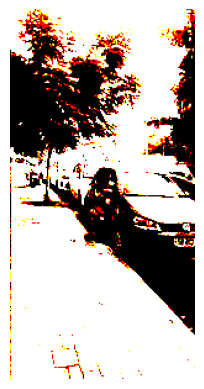

Predicted label: 3, True lable: 1


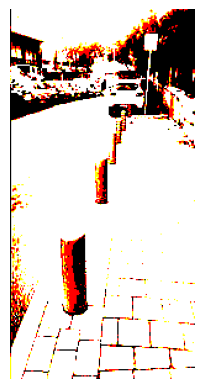

Predicted label: 3, True lable: 0


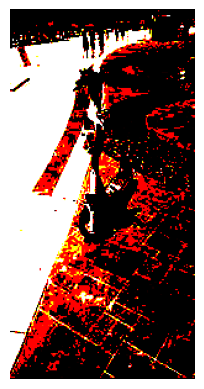

Predicted label: 0, True lable: 3


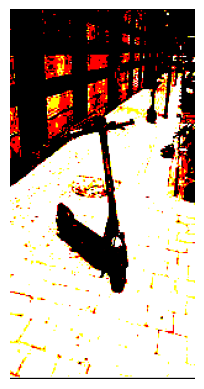

Predicted label: 0, True lable: 3


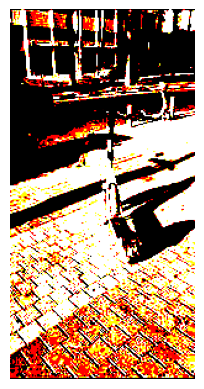

Predicted label: 3, True lable: 0


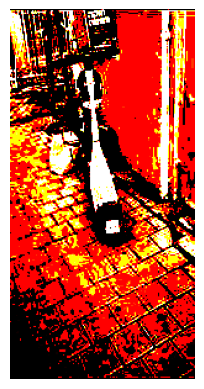

Predicted label: 0, True lable: 3


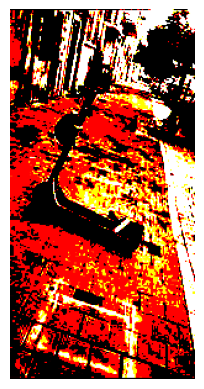

Predicted label: 0, True lable: 3


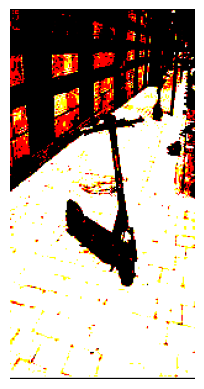

Predicted label: 0, True lable: 3


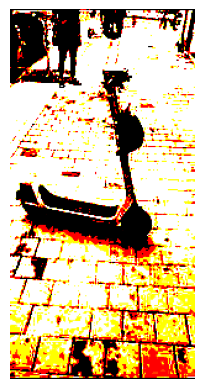

Predicted label: 2, True lable: 3


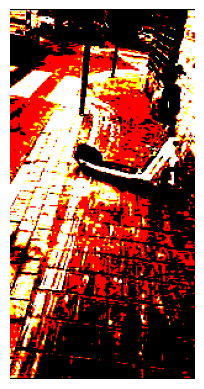

Predicted label: 0, True lable: 3


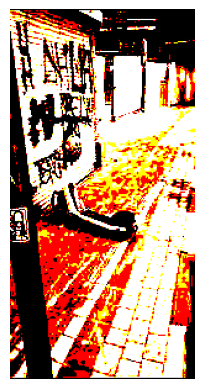

Predicted label: 3, True lable: 0


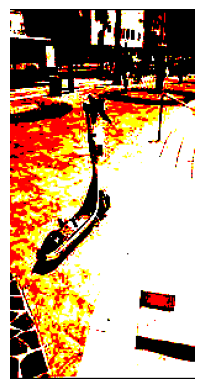

Predicted label: 3, True lable: 0


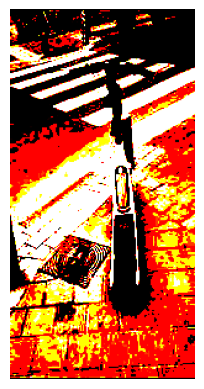

Predicted label: 1, True lable: 0


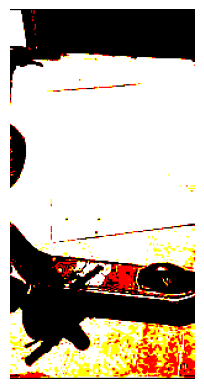

Predicted label: 3, True lable: 0


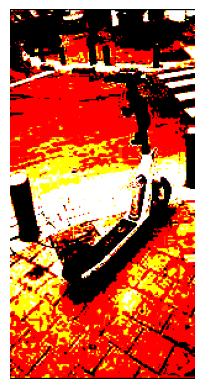

Predicted label: 0, True lable: 1


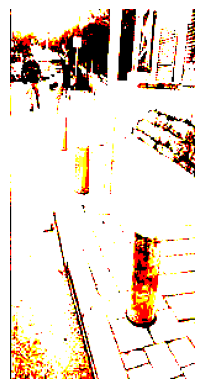

Predicted label: 0, True lable: 3


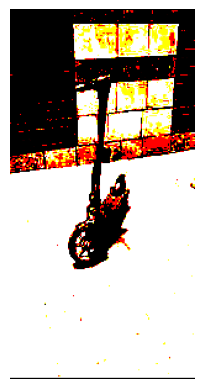

Predicted label: 3, True lable: 0


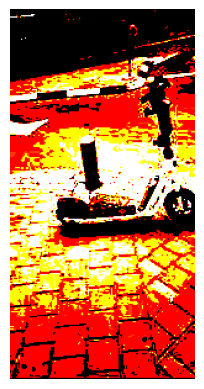

Predicted label: 0, True lable: 3


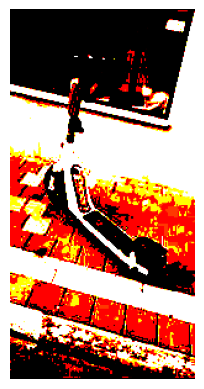

Predicted label: 3, True lable: 0


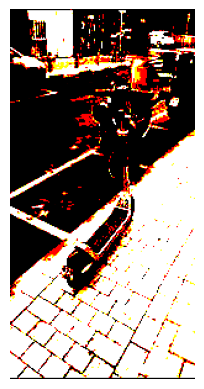

Predicted label: 3, True lable: 0


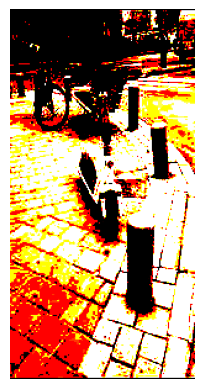

Predicted label: 0, True lable: 1


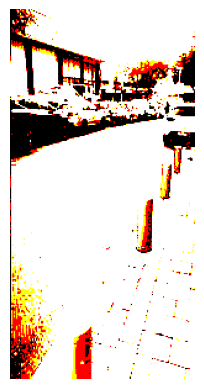

Predicted label: 0, True lable: 1


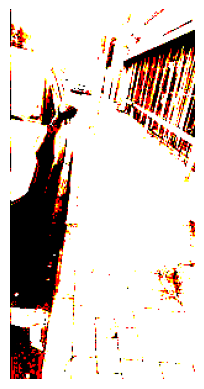

Predicted label: 0, True lable: 3


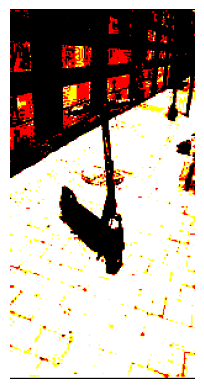

Predicted label: 3, True lable: 2


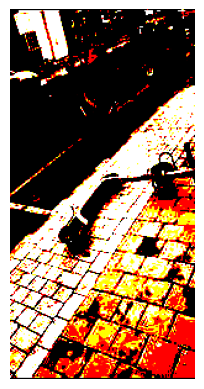

Predicted label: 0, True lable: 3


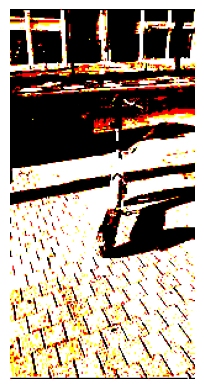

Predicted label: 3, True lable: 0


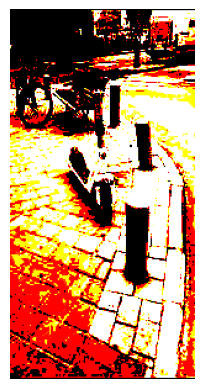

Predicted label: 3, True lable: 0


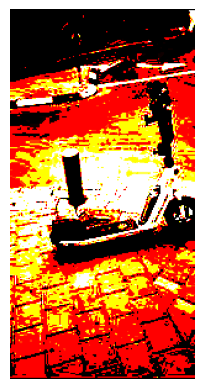

Predicted label: 0, True lable: 3


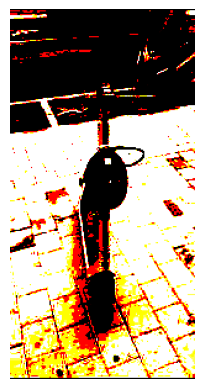

Predicted label: 0, True lable: 3


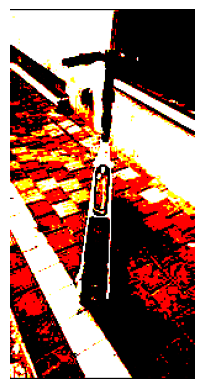

Predicted label: 1, True lable: 0


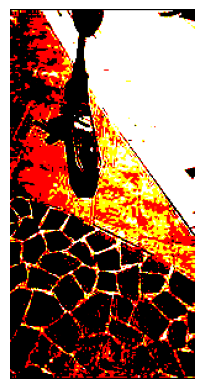

Predicted label: 0, True lable: 3


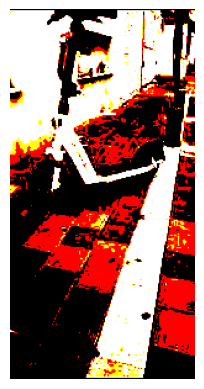

Predicted label: 0, True lable: 3


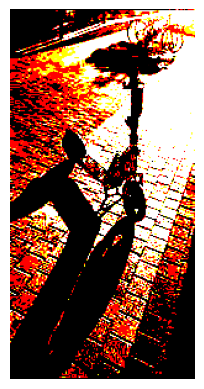

Predicted label: 0, True lable: 3


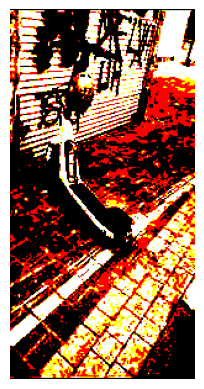

Predicted label: 3, True lable: 1


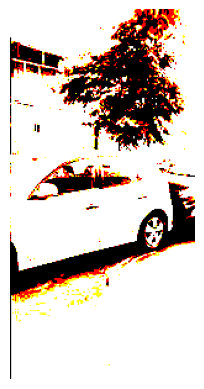

Predicted label: 0, True lable: 3


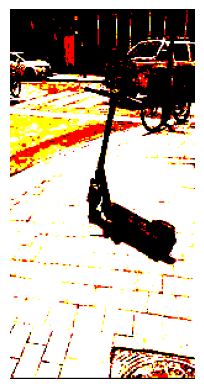

Predicted label: 3, True lable: 0


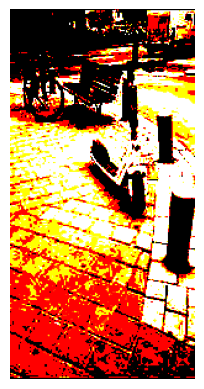

Predicted label: 0, True lable: 3


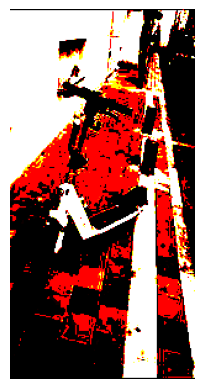

Predicted label: 1, True lable: 0

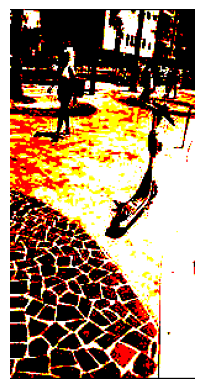

Predicted label: 1, True lable: 0


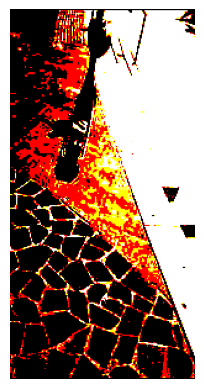

Predicted label: 0, True lable: 3


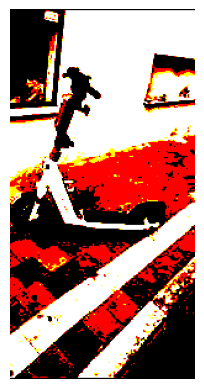

Predicted label: 3, True lable: 0


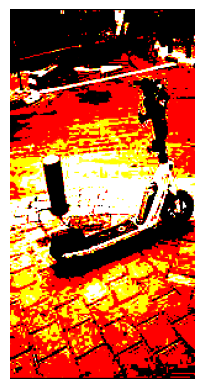

Predicted label: 3, True lable: 0


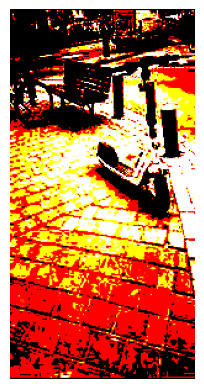

Predicted label: 0, True lable: 1


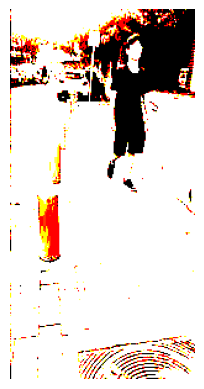

Predicted label: 3, True lable: 0


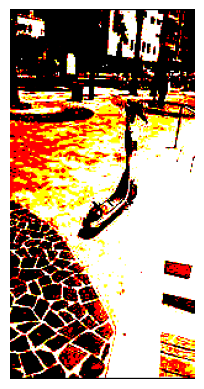

Predicted label: 2, True lable: 3


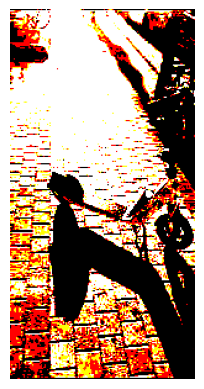

Predicted label: 3, True lable: 0


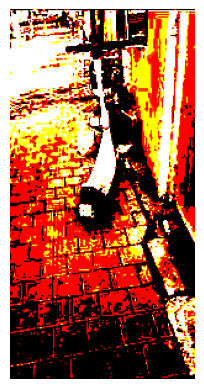

Predicted label: 0, True lable: 3


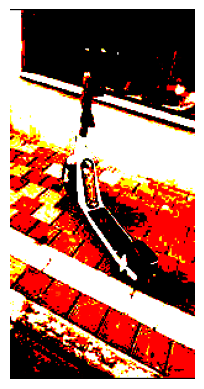

Predicted label: 3, True lable: 1


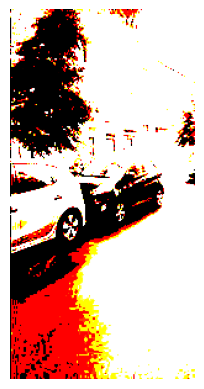

Predicted label: 0, True lable: 3


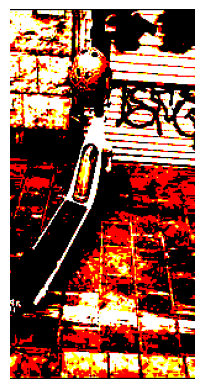

Predicted label: 3, True lable: 0


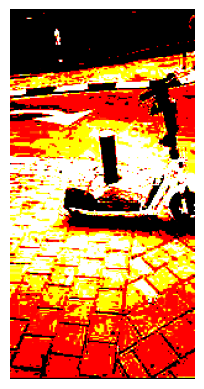

Predicted label: 0, True lable: 3


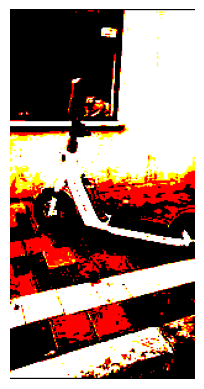

Predicted label: 3, True lable: 0


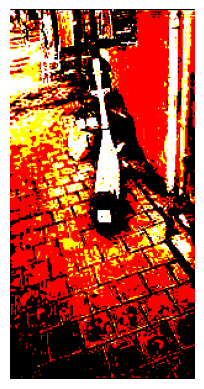

Predicted label: 0, True lable: 3


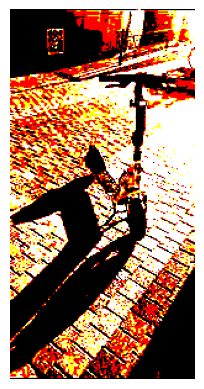

Predicted label: 0, True lable: 3


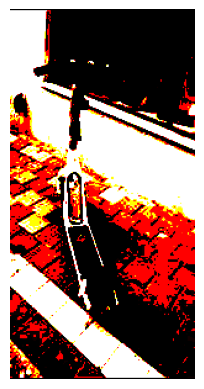

Predicted label: 0, True lable: 3


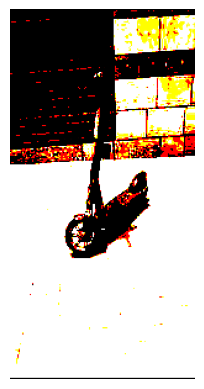

Predicted label: 0, True lable: 3


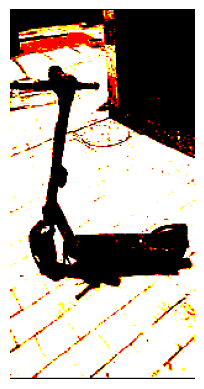

Predicted label: 3, True lable: 0


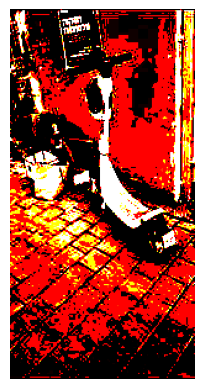

In [154]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a NumPy array called 'image_array'
# containing the image data

for index in indices[0]:
  print(f"Predicted label: {predicted_labels[index]}, True lable: {test_labels[index]}")
  plt.imshow(test_images[index])
  plt.axis('off')  # Optional: turn off the axis labels
  plt.show()

In [155]:
from sklearn import metrics

In [156]:
classification_report = metrics.classification_report(test_labels, predicted_labels)
print(classification_report)

              precision    recall  f1-score   support

           0       0.49      0.57      0.52        90
           1       0.94      0.88      0.91       144
           2       0.94      0.92      0.93        50
           3       0.64      0.61      0.63       116

    accuracy                           0.74       400
   macro avg       0.75      0.75      0.75       400
weighted avg       0.75      0.74      0.74       400

